In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [3]:
df_hsi = pd.read_csv('^HSI.csv')[['Date', 'Adj Close']]
df_spx = pd.read_csv('^GSPC.csv')[['Date', 'Adj Close']]
df_hsi.rename(columns={'Adj Close':'hsi'}, inplace=True)
df_spx.rename(columns={'Adj Close':'spx'}, inplace=True)
df = df_hsi.merge(df_spx, on='Date').dropna()

In [4]:
df = pd.read_csv('^GSPC.csv')[['Date', 'Close']]
df

,Date,Close
0,2001-01-02,1283.270020
1,2001-01-03,1347.560059
2,2001-01-04,1333.339966
3,2001-01-05,1298.349976
4,2001-01-08,1295.859985
...,...,...
3768,2015-12-24,2060.989990
3769,2015-12-28,2056.500000
3770,2015-12-29,2078.360107
3771,2015-12-30,2063.360107


In [5]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.9.0
pandas==0.25.1
numpy==1.17.2
matplotlib==3.1.1


In [7]:
# df = pd.read_csv('../dataset/GOOG-year.csv')
# df.head()

In [8]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [9]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [13]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 1000, checkpoint = 10)

iter 10. reward: 119.844886
iter 20. reward: 132.124609
iter 30. reward: 152.308195
iter 40. reward: 191.716610
iter 50. reward: 189.084491
iter 60. reward: 192.320305
iter 70. reward: 211.738204
iter 80. reward: 221.614913
iter 90. reward: 234.716706
iter 100. reward: 272.365492
iter 110. reward: 257.359085
iter 120. reward: 243.700095
iter 130. reward: 240.667302
iter 140. reward: 228.759603
iter 150. reward: 239.268588
iter 160. reward: 267.343684
iter 170. reward: 273.859785
iter 180. reward: 233.849880
iter 190. reward: 270.852894
iter 200. reward: 294.119386
iter 210. reward: 264.998789
iter 220. reward: 293.902793
iter 230. reward: 309.977891
iter 240. reward: 286.912096
iter 250. reward: 305.771580
iter 260. reward: 288.260984
iter 270. reward: 296.643494
iter 280. reward: 291.590693
iter 290. reward: 329.770499
iter 300. reward: 309.187991
iter 310. reward: 349.698786
iter 320. reward: 326.590884
iter 330. reward: 322.551887
iter 340. reward: 336.120792
iter 350. reward: 318.1

In [14]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 0: buy 1 unit at price 1283.270020, total balance 8716.729980
day 1, sell 1 unit at price 1347.560059, investment 5.009861 %, total balance 10064.290039,
day 2: buy 1 unit at price 1333.339966, total balance 8730.950073
day 4: buy 1 unit at price 1295.859985, total balance 7435.090088
day 6, sell 1 unit at price 1313.270020, investment -1.505238 %, total balance 8748.360108,
day 7, sell 1 unit at price 1326.819946, investment 2.389144 %, total balance 10075.180054,
day 8: buy 1 unit at price 1318.550049, total balance 8756.630005
day 11, sell 1 unit at price 1347.969971, investment 2.231233 %, total balance 10104.599976,
day 12: buy 1 unit at price 1342.540039, total balance 8762.059937
day 13, sell 1 unit at price 1342.900024, investment 0.026814 %, total balance 10104.959961,
day 16: buy 1 unit at price 1357.510010, total balance 8747.449951
day 17, sell 1 unit at price 1354.949951, investment -0.188585 %, total balance 10102.399902,
day 19: buy 1 unit at price 1373.729980, total

day 272: buy 1 unit at price 1083.510010, total balance 982.920169
day 273, sell 1 unit at price 1080.170044, investment -7.303026 %, total balance 2063.090213,
day 274, sell 1 unit at price 1096.219971, investment -5.556081 %, total balance 3159.310184,
day 275, sell 1 unit at price 1111.939941, investment -3.739813 %, total balance 4271.250125,
day 276: buy 1 unit at price 1107.500000, total balance 3163.750125
day 278: buy 1 unit at price 1116.479980, total balance 2047.270145
day 279, sell 1 unit at price 1104.180054, investment -2.075232 %, total balance 3151.450199,
day 280: buy 1 unit at price 1083.339966, total balance 2068.110233
day 281, sell 1 unit at price 1097.979980, investment -0.241681 %, total balance 3166.090213,
day 282: buy 1 unit at price 1080.949951, total balance 2085.140262
day 283, sell 1 unit at price 1089.839966, investment -3.571048 %, total balance 3174.980228,
day 284, sell 1 unit at price 1109.430054, investment 1.369661 %, total balance 4284.410282,
day 

day 531: buy 1 unit at price 851.169983, total balance 355.220896
day 533, sell 1 unit at price 837.099976, investment -7.912836 %, total balance 1192.320872,
day 535: buy 1 unit at price 832.580017, total balance 359.740855
day 536, sell 1 unit at price 838.570007, investment -7.842360 %, total balance 1198.310862,
day 537: buy 1 unit at price 827.549988, total balance 370.760874
day 541, sell 1 unit at price 821.989990, investment -11.257100 %, total balance 1192.750864,
day 542, sell 1 unit at price 829.849976, investment -7.976452 %, total balance 2022.600840,
day 543: buy 1 unit at price 822.099976, total balance 1200.500864
day 544, sell 1 unit at price 828.890015, investment -3.774090 %, total balance 2029.390879,
day 545: buy 1 unit at price 807.479980, total balance 1221.910899
day 547: buy 1 unit at price 804.190002, total balance 417.720897
day 550, sell 1 unit at price 862.789978, investment 1.806532 %, total balance 1280.510875,
day 551: buy 1 unit at price 866.450012, tot

day 805: buy 1 unit at price 1109.780029, total balance 5371.680676
day 806: buy 1 unit at price 1095.400024, total balance 4276.280652
day 808: buy 1 unit at price 1091.329956, total balance 3184.950696
day 809: buy 1 unit at price 1109.189941, total balance 2075.760755
day 811: buy 1 unit at price 1122.469971, total balance 953.290784
day 814, sell 1 unit at price 1132.170044, investment -2.145217 %, total balance 2085.460828,
day 815, sell 1 unit at price 1141.810059, investment -0.201023 %, total balance 3227.270887,
day 816, sell 1 unit at price 1150.569946, investment 1.007820 %, total balance 4377.840833,
day 818: buy 1 unit at price 1140.530029, total balance 3237.310804
day 822: buy 1 unit at price 1128.170044, total balance 2109.140760
day 824, sell 1 unit at price 1134.609985, investment -1.426552 %, total balance 3243.750745,
day 825, sell 1 unit at price 1135.819946, investment -1.649541 %, total balance 4379.570691,
day 826: buy 1 unit at price 1118.150024, total balance 

day 1048: buy 1 unit at price 1219.430054, total balance 4958.350964
day 1050: buy 1 unit at price 1209.250000, total balance 3749.100964
day 1052, sell 1 unit at price 1206.829956, investment 3.028102 %, total balance 4955.930920,
day 1054: buy 1 unit at price 1188.069946, total balance 3767.860974
day 1056, sell 1 unit at price 1189.650024, investment -0.196308 %, total balance 4957.510998,
day 1058: buy 1 unit at price 1171.709961, total balance 3785.801037
day 1059: buy 1 unit at price 1172.530029, total balance 2613.271008
day 1061: buy 1 unit at price 1174.280029, total balance 1438.990979
day 1062: buy 1 unit at price 1165.359985, total balance 273.630994
day 1063, sell 1 unit at price 1181.410034, investment -1.982080 %, total balance 1455.041028,
day 1064: buy 1 unit at price 1180.589966, total balance 274.451062
day 1066, sell 1 unit at price 1176.119995, investment -2.051218 %, total balance 1450.571057,
day 1068: buy 1 unit at price 1184.069946, total balance 266.501111
day

day 1410: buy 1 unit at price 1268.209961, total balance 235.561301
day 1411, sell 1 unit at price 1285.579956, investment 2.665709 %, total balance 1521.141257,
day 1413: buy 1 unit at price 1297.479980, total balance 223.661277
day 1415, sell 1 unit at price 1297.520020, investment 4.706268 %, total balance 1521.181297,
day 1416, sell 1 unit at price 1298.819946, investment 2.253188 %, total balance 2820.001243,
day 1417: buy 1 unit at price 1292.989990, total balance 1527.011253
day 1419: buy 1 unit at price 1295.089966, total balance 231.921287
day 1424, sell 1 unit at price 1311.010010, investment 3.155218 %, total balance 1542.931297,
day 1425: buy 1 unit at price 1313.250000, total balance 229.681297
day 1426, sell 1 unit at price 1300.260010, investment 2.748367 %, total balance 1529.941307,
day 1429: buy 1 unit at price 1299.540039, total balance 230.401268
day 1435, sell 1 unit at price 1317.640015, investment 3.553041 %, total balance 1548.041283,
day 1436, sell 1 unit at pr

day 1759, sell 1 unit at price 1447.160034, investment -2.512693 %, total balance 15381.991362,
day 1761, sell 1 unit at price 1416.180054, investment -5.440486 %, total balance 16798.171416,
day 1764: buy 1 unit at price 1420.329956, total balance 15377.841460
day 1765, sell 1 unit at price 1401.020020, investment -4.586066 %, total balance 16778.861480,
day 1766, sell 1 unit at price 1416.250000, investment -2.135910 %, total balance 18195.111480,
day 1767: buy 1 unit at price 1380.949951, total balance 16814.161529
day 1768: buy 1 unit at price 1373.199951, total balance 15440.961578
day 1770: buy 1 unit at price 1325.189941, total balance 14115.771637
day 1771: buy 1 unit at price 1310.500000, total balance 12805.271637
day 1772: buy 1 unit at price 1338.599976, total balance 11466.671661
day 1773, sell 1 unit at price 1352.069946, investment -4.805926 %, total balance 12818.741607,
day 1774: buy 1 unit at price 1330.609985, total balance 11488.131622
day 1775, sell 1 unit at price

day 1989: buy 1 unit at price 816.210022, total balance 17073.931055
day 1990, sell 1 unit at price 848.809998, investment 5.235684 %, total balance 17922.741053,
day 1991, sell 1 unit at price 870.739990, investment 15.722182 %, total balance 18793.481043,
day 1992: buy 1 unit at price 845.219971, total balance 17948.261072
day 1993: buy 1 unit at price 876.070007, total balance 17072.191065
day 1996: buy 1 unit at price 899.239990, total balance 16172.951075
day 1997, sell 1 unit at price 873.590027, investment 2.556912 %, total balance 17046.541102,
day 1999: buy 1 unit at price 868.570007, total balance 16177.971095
day 2000, sell 1 unit at price 913.179993, investment 11.880517 %, total balance 17091.151088,
day 2001: buy 1 unit at price 904.419983, total balance 16186.731105
day 2002: buy 1 unit at price 885.280029, total balance 15301.451076
day 2003, sell 1 unit at price 887.880005, investment 5.047211 %, total balance 16189.331081,
day 2005: buy 1 unit at price 863.159973, tot

day 2255: buy 1 unit at price 1114.050049, total balance 861.081084
day 2257, sell 1 unit at price 1120.589966, investment 8.440343 %, total balance 1981.671050,
day 2259: buy 1 unit at price 1127.780029, total balance 853.891021
day 2260, sell 1 unit at price 1126.199951, investment 6.989155 %, total balance 1980.090972,
day 2263: buy 1 unit at price 1132.989990, total balance 847.100982
day 2265, sell 1 unit at price 1137.140015, investment 6.398069 %, total balance 1984.240997,
day 2267, sell 1 unit at price 1144.979980, investment 7.544187 %, total balance 3129.220977,
day 2270, sell 1 unit at price 1145.680054, investment 7.994388 %, total balance 4274.901031,
day 2271, sell 1 unit at price 1148.459961, investment 8.282967 %, total balance 5423.360992,
day 2272: buy 1 unit at price 1136.030029, total balance 4287.330963
day 2273, sell 1 unit at price 1150.229980, investment 11.689082 %, total balance 5437.560943,
day 2274: buy 1 unit at price 1138.040039, total balance 4299.520904

day 2546: buy 1 unit at price 1336.319946, total balance 6354.140597
day 2547, sell 1 unit at price 1340.430054, investment 13.055399 %, total balance 7694.570651,
day 2549: buy 1 unit at price 1315.439941, total balance 6379.130710
day 2551, sell 1 unit at price 1306.099976, investment 10.381485 %, total balance 7685.230686,
day 2553: buy 1 unit at price 1327.219971, total balance 6358.010715
day 2554: buy 1 unit at price 1306.329956, total balance 5051.680759
day 2557: buy 1 unit at price 1321.150024, total balance 3730.530735
day 2558, sell 1 unit at price 1310.130005, investment 9.765666 %, total balance 5040.660740,
day 2559, sell 1 unit at price 1321.819946, investment 10.358585 %, total balance 6362.480686,
day 2561: buy 1 unit at price 1295.109985, total balance 5067.370701
day 2563: buy 1 unit at price 1296.390015, total balance 3770.980686
day 2565: buy 1 unit at price 1256.880005, total balance 2514.100681
day 2567: buy 1 unit at price 1279.209961, total balance 1234.890720


day 2721, sell 1 unit at price 1242.000000, investment -1.455160 %, total balance 1683.430272,
day 2722, sell 1 unit at price 1284.589966, investment 14.750863 %, total balance 2968.020238,
day 2723, sell 1 unit at price 1285.089966, investment 14.662368 %, total balance 4253.110204,
day 2724: buy 1 unit at price 1253.300049, total balance 2999.810155
day 2728: buy 1 unit at price 1253.229980, total balance 1746.580175
day 2729, sell 1 unit at price 1261.119995, investment 6.982460 %, total balance 3007.700170,
day 2730: buy 1 unit at price 1275.920044, total balance 1731.780126
day 2732, sell 1 unit at price 1239.699951, investment 3.935405 %, total balance 2971.480077,
day 2733: buy 1 unit at price 1263.849976, total balance 1707.630101
day 2734, sell 1 unit at price 1251.780029, investment 9.742691 %, total balance 2959.410130,
day 2736: buy 1 unit at price 1236.910034, total balance 1722.500096
day 2737: buy 1 unit at price 1216.130005, total balance 506.370091
day 2738, sell 1 uni

day 2988, sell 1 unit at price 1386.890015, investment 1.975706 %, total balance 1667.220551,
day 2989, sell 1 unit at price 1387.810059, investment 0.181189 %, total balance 3055.030610,
day 2990: buy 1 unit at price 1391.030029, total balance 1664.000581
day 2991, sell 1 unit at price 1409.150024, investment 0.494220 %, total balance 3073.150605,
day 2994: buy 1 unit at price 1409.930054, total balance 1663.220551
day 2995: buy 1 unit at price 1415.949951, total balance 247.270600
day 2999, sell 1 unit at price 1409.280029, investment 0.368208 %, total balance 1656.550629,
day 3000, sell 1 unit at price 1413.939941, investment 0.054480 %, total balance 3070.490570,
day 3001: buy 1 unit at price 1418.069946, total balance 1652.420624
day 3003, sell 1 unit at price 1427.839966, investment 1.233659 %, total balance 3080.260590,
day 3005: buy 1 unit at price 1419.449951, total balance 1660.810639
day 3006: buy 1 unit at price 1413.579956, total balance 247.230683
day 3007, sell 1 unit at

day 3211: buy 1 unit at price 1656.400024, total balance 2039.220793
day 3212, sell 1 unit at price 1692.560059, investment 5.371419 %, total balance 3731.780852,
day 3213: buy 1 unit at price 1703.199951, total balance 2028.580901
day 3217: buy 1 unit at price 1733.150024, total balance 295.430877
day 3218, sell 1 unit at price 1744.500000, investment 7.991158 %, total balance 2039.930877,
day 3219: buy 1 unit at price 1744.660034, total balance 295.270843
day 3224, sell 1 unit at price 1762.109985, investment 7.979703 %, total balance 2057.380828,
day 3225, sell 1 unit at price 1771.949951, investment 7.240124 %, total balance 3829.330779,
day 3227: buy 1 unit at price 1756.540039, total balance 2072.790740
day 3228, sell 1 unit at price 1761.640015, investment 6.596799 %, total balance 3834.430755,
day 3229, sell 1 unit at price 1767.930054, investment 4.509209 %, total balance 5602.360809,
day 3231: buy 1 unit at price 1770.489990, total balance 3831.870819
day 3234: buy 1 unit at 

day 3550: buy 1 unit at price 2096.989990, total balance 31245.541596
day 3554, sell 1 unit at price 2110.300049, investment 0.943761 %, total balance 33355.841645,
day 3555, sell 1 unit at price 2109.659912, investment 2.465395 %, total balance 35465.501557,
day 3556, sell 1 unit at price 2115.479980, investment 4.696673 %, total balance 37580.981537,
day 3557, sell 1 unit at price 2113.860107, investment 6.081793 %, total balance 39694.841644,
day 3558, sell 1 unit at price 2110.739990, investment 4.360334 %, total balance 41805.581634,
day 3563, sell 1 unit at price 2101.040039, investment 1.836519 %, total balance 43906.621673,
day 3565, sell 1 unit at price 2079.429932, investment 2.878413 %, total balance 45986.051605,
day 3566: buy 1 unit at price 2044.160034, total balance 43941.891571
day 3568, sell 1 unit at price 2065.949951, investment 3.556908 %, total balance 46007.841522,
day 3569: buy 1 unit at price 2053.399902, total balance 43954.441620
day 3570, sell 1 unit at price

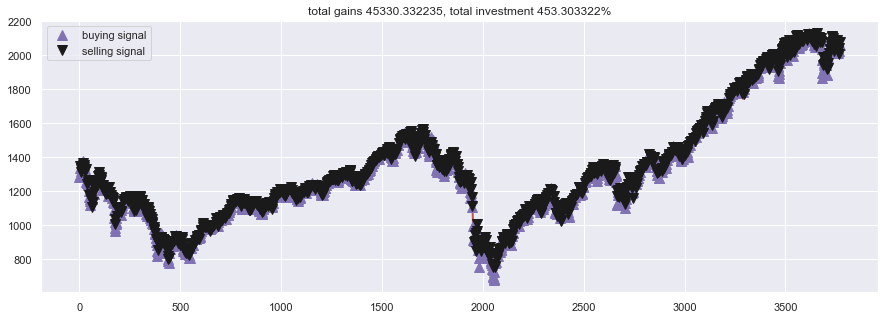

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()